In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.patches as patches
from matplotlib import font_manager
import re
import os
from matplotlib.offsetbox import AnnotationBbox

In [37]:
class Dragome:
    @staticmethod
    # 读取 ClevaeLand 输出的信息文件以及整理的含保守结构域的 csv 文件
    def Read_result_file (result_file,Conserved_file):
        
        Outfile = result_file +".csv"
        print (f'Inputfile is {result_file} {Conserved_file}\nOutfile is {Outfile}')
        ## 读取含保守结构域的 csv 文件
        Conserved_df = pd.read_csv(Conserved_file,header=None,names=['Conserved_Gene','Conserved_start','Conserved_end'])
        
        ## 读取 ClevaeLand 输出的信息文件
        with open(result_file, 'r') as f:
            miRNA_pos = []  # 靶位点比对信息的列表
            Category = 0  # 存储 Category 行
            T_plot_message_file = ""  # 存储 T-Plot file行
            score = 0  # 存储分数
            Message = []  # 存储所有信息
            for line in f:
                if line.startswith("5'"):
                    ## 检测到 miRNA 切割信息,开始处理上一段的切割信息,并整理其他信息到列表中
                    if miRNA_pos:
                        miRNA_target = ''
                        Tr_seq = re.findall(r'(.*?)Transcript: (.*?):\d+-\d+', miRNA_pos[0])[0]
                        miRNA_pos[0] = Tr_seq[0]+Tr_seq[1]+'\n'
                        miRNA_seq = re.findall(r'(.*?)Query: (.*?)$', miRNA_pos[2])[0]
                        miRNA_pos[2] = miRNA_seq[0] + miRNA_seq[1]
                        miRNA_pos[2] = miRNA_seq[0]+miRNA_seq[1]
                        miRNA_target = miRNA_pos[0] + miRNA_pos[1] + miRNA_pos[2]
                        # print (miRNA_target)
                        Message.append([gene,miRNA,T_plot_message_file,score,Category,p_value,miRNA_target,T_plot_fig_message_file])
                    miRNA_pos = []  # 将前三行列表重置为空列表
                    miRNA_pos.append(line)  # 将当前行添加到前三行列表中

                elif miRNA_pos and len(miRNA_pos) < 3:  # 如果前三行列表非空且长度小于 3 ，则继续添加行至前三行列表中，获取完整的 miRNA 靶向序列
                    miRNA_pos.append(line)
                    
                    ## 提取 score
                elif (re.findall(r'Allen et al. score: (\d+(\.\d+)?)',line)):
                    score = float(re.findall(r'Allen et al. score: (\d+(\.\d+)?)',line)[0][0])
                    # print (score)
                    
                    ## 提取 Category
                elif (re.findall(r'Degardome Category: (\d?)',line)):
                    Category = int((re.findall(r'Degardome Category: (.\d?)',line)[0]))
                    # print (Category)
                    
                    ## 提取 p 值
                elif (re.findall(r'Degradome p-value: (.*\d.\d?)',line)):
                    p_value = float(re.findall(r'Degradome p-value: (.*\d.\d?)',line)[0])
                    p_value = round(p_value, 6)
                    #print (p_value)
                    
                    ## 提取绘图的数据文件,参考 CleaveLand4.pl 中 make_t_plot 函数进行修改
                elif (line.startswith("T-Plot file:")):
                    a = re.findall(r'(.*?).png',line)[0]
                    T_plot_message_file = os.path.basename(a) + '_tmp.txt'
                    T_plot_fig_message_file = os.path.basename(a) + '.test.pdf'
                    # print (T_plot_message_file)
                    miRNA,gene,Site = line.strip().split('/')[1].split('_')[0:3]
                    ## 提取基因以及miRNA信息
                # elif (line.startswith("SiteID:")):
                #     _,gene,miRNA = line.strip().split(':')
                #     miRNA = 'miR' + miRNA
                #     gene = gene.strip()
            # 处理最后一个结构的前三行数据
            if miRNA_pos:
                Tr_seq = re.findall(r'(.*?)Transcript: (.*?):\d+-\d+', miRNA_pos[0])[0]
                miRNA_pos[0] = Tr_seq[0]+Tr_seq[1]+'\n'
                miRNA_seq = re.findall(r'(.*?)Query: (.*?)$', miRNA_pos[2])[0]
                miRNA_pos[2] = miRNA_seq[0] + miRNA_seq[1]
                miRNA_pos[2] = miRNA_seq[0]+miRNA_seq[1]
                miRNA_target = miRNA_pos[0] + miRNA_pos[1] + miRNA_pos[2]
            # print (miRNA_target)
            Message.append([gene,miRNA,T_plot_message_file,score,Category,p_value,miRNA_target,T_plot_fig_message_file])
        ## 生成信息矩阵
        Message_df = pd.DataFrame(Message)
        Message_df.columns=["gene","miRNA","T_plot_message_file","score","Category","p_value","miRNA_target","T_plot_fig_message_file"]
        
        ## 匹配保守结构域
        Conserved_gene = set(Conserved_df['Conserved_Gene'])
        for gene in Conserved_gene:
            Select_df = Conserved_df[Conserved_df['Conserved_Gene']==gene]
            for i in  range(len(Select_df)):
                Conserved_start = f'Conserved{i+1}_start'
                Conserved_end = f'Conserved{i+1}_end'
                Message_df.loc[:,Conserved_start] = Select_df.iloc[i]['Conserved_start']
                Message_df.loc[:,Conserved_end] = Select_df.iloc[i]['Conserved_end']
        Message_df.to_csv(Outfile,index=False)
        return Message_df
    @staticmethod
    ## 绘图
    def Draw(Series):
        # 读取整理的数据
        gene,miRNA,Draw_data_file,score,Category,p_value,miRNA_target,Save_fig,Conserved1_start,Conserved1_end,Conserved2_start,Conserved2_end = Series[0:12]
        data = pd.read_csv(Draw_data_file,sep='\t')
        ###################################################################################################
        ## 绘制 T-plot
        ax1 = plt.subplot2grid((14,12),(0,0),rowspan=8,colspan=6)
        ax1.plot(data['Position'], data['All'], color='black')
        # 获取切割位点 Site 所在的 Series
        df_notnan = data[~data['Site'].isna()]
        # 获取位点
        Site = df_notnan.iloc[0,0]
        # 获取位点切割分数
        Site_height = df_notnan.iloc[0,2]
        # 获取 y 轴长度
        y_len = plt.ylim()[1] - plt.ylim()[0]
        # 获取分数相对于 y 轴长度的比值，用于做图
        Site_len = float((Site_height-(plt.ylim()[0]))/(y_len))
        ax1.axvline(x=Site, color=(251/255,87/255,84/255), ymin=0,ymax=Site_len,linestyle='-')
        plt.xlabel('Transcript Position')
        plt.ylabel("Degradome 5' end Frequency")
        plt.title('Degradome Data')
        x_len = plt.xlim()[1] - plt.xlim()[0]
        ax1_annotation = 'Category=' + str(Category) + "\n" + 'P=' + str(p_value)
        plt.text(0.6,0.8,ax1_annotation,transform=ax1.transAxes,fontsize=10)
        print (x_len)
        ####################################################################################################
        ## 绘制保守结构域
        ax2 = plt.subplot2grid((14,12),(10,0),rowspan=1,colspan=6,sharex=ax1)
        ## 按照 CDS 长度绘制最下层的图
        rect1 = plt.Rectangle((0, 0), x_len, 0.5, facecolor=(240/255,90/255,217/255), alpha=0.5)
        ## 第一个结构域
        rect2 = plt.Rectangle((Conserved1_start, 0), (Conserved1_end-Conserved1_start), 0.5, facecolor=(255/255,217/255,48/255), alpha=0.5)
        ## 第二个结构域
        rect3 = plt.Rectangle((Conserved2_start, 0), (Conserved2_end-Conserved2_start), 0.5, facecolor=(255/255,217/255,48/255), alpha=0.5)
        ax2.add_patch(rect1)
        ax2.add_patch(rect2)
        ax2.add_patch(rect3)
        ## 隐藏坐标轴
        ax2.axis('off')
        ###################################################################################################
        ## 绘制miRNA的切割信息
        ax3 = plt.subplot2grid((14,12),(13,0),rowspan=1,colspan=6)
        ax3.text(0.1,-0.5,miRNA_target,fontproperties=font_manager.FontProperties(fname='/home/xurong_fan/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/consola.ttf'))
        ax3.axis('off')
        ###################################################################################################
        ## 绘制连接线
        xy = (Site, 0) 
        con = patches.ConnectionPatch( 
            xyA = xy, coordsA = ax2.transData, 
            xyB = xy, coordsB = ax1.transData, 
            linestyle="--", linewidth=1.5,edgecolor="red")
        ax2.add_artist(con) 
        text_xy = (0.5,3)
        con_text = patches.ConnectionPatch( 
            xyA = xy, coordsA = ax2.transData, 
            xyB = text_xy, coordsB = ax3.transData, 
            linestyle="--", linewidth=1.5,edgecolor="red")
        ax3.add_artist(con_text)
        final_xy = (0.5,1.5)
        con_final = patches.ConnectionPatch(xyA = text_xy, xyB = final_xy, 
                              coordsA=ax3.transData, coordsB=ax3.transData, arrowstyle="->", shrinkB=5,edgecolor="red")
        ax3.add_artist(con_final)
        # ax3.plot([xyA[0]], [xyA[1]], "o") 
        subtitle = f'{gene} -----> {miRNA}'
        plt.suptitle(subtitle,x=(8/12/2),y=1)
        plt.tight_layout()
        plt.savefig(Save_fig)
        print (f'Out Fig is {Save_fig}')

In [38]:
a = Dragome.Read_result_file('flower.txt','AP2_cds_cd_search.txt')

Inputfile is flower.txt AP2_cds_cd_search.txt
Outfile is flower.txt.csv


In [39]:
Select_df = a[ (a['score']<=5) & (a['Category']<=2)]
Select_df = Select_df.reset_index(drop=True)

In [31]:
Select_gene = set(Select_df['gene'])
Target_df = pd.DataFrame
Target_gene =[]
with open ('Lch.id','r') as f:
    for line in f:
        gene = line.strip()
        for index, row in Select_df.iterrows():
            if row['gene']  == gene:
                Target_gene.append(index)

1655.5


/tmp/ipykernel_41996/3710119677.py:158: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


Out Fig is miR172a_LITCHI006915.m1_1423_TPlot.test.pdf
1576.3000000000002


/tmp/ipykernel_41996/3710119677.py:158: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


Out Fig is miR172a_LITCHI018533.m1_1291_TPlot.test.pdf
1705.0


/tmp/ipykernel_41996/3710119677.py:158: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


Out Fig is miR172a_LITCHI024773.m2_1390_TPlot.test.pdf
1655.5


/tmp/ipykernel_41996/3710119677.py:158: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


Out Fig is miR172a_LITCHI027926.m1_1375_TPlot.test.pdf


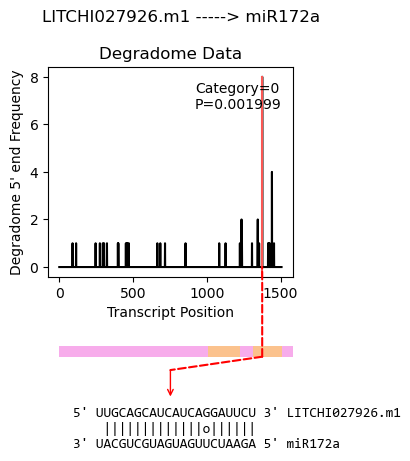

In [41]:
for index in Target_gene:
    Series = Select_df.iloc[index,:]
    Dragome.Draw(Series)

In [40]:
Select_df.head(10)

,gene,miRNA,T_plot_message_file,score,Category,p_value,miRNA_target,T_plot_fig_message_file,Conserved1_start,Conserved1_end,Conserved2_start,Conserved2_end
0,LITCHI000620.m1,miR482e,miR482e_LITCHI000620.m1_168_TPlot_tmp.txt,3.0,0,0.009160,5' GGAAUGGGAGCUGUUGGAAAGA 3' LITCHI000620.m1\n...,miR482e_LITCHI000620.m1_168_TPlot.test.pdf,1006,1224,1315,1506
1,LITCHI001168.m1,miR394,miR394_LITCHI001168.m1_767_TPlot_tmp.txt,5.0,2,0.145356,5' GGAGGCGGGCAGAGGUGCCAA 3' LITCHI001168.m1\n ...,miR394_LITCHI001168.m1_767_TPlot.test.pdf,1006,1224,1315,1506
2,LITCHI001448.m1,miRN11,miRN11_LITCHI001448.m1_415_TPlot_tmp.txt,4.0,2,0.184694,5' GGGAUUCUAGAAACCGGAGAA 3' LITCHI001448.m1\n ...,miRN11_LITCHI001448.m1_415_TPlot.test.pdf,1006,1224,1315,1506
3,LITCHI001702.m1,miR159c,miR159c_LITCHI001702.m1_790_TPlot_tmp.txt,4.0,0,0.123691,5' AAGAACCCCCUUCAAUCCAAU 3' LITCHI001702.m1\n ...,miR159c_LITCHI001702.m1_790_TPlot.test.pdf,1006,1224,1315,1506
4,LITCHI002284.m1,miR482e,miR482e_LITCHI002284.m1_523_TPlot_tmp.txt,5.0,2,0.985378,5' UGUAUUGGGUGGUGUUGUGAAAGA 3' LITCHI002284.m1...,miR482e_LITCHI002284.m1_523_TPlot.test.pdf,1006,1224,1315,1506
5,LITCHI002638.m1,miR482e,miR482e_LITCHI002638.m1_205_TPlot_tmp.txt,1.0,0,0.002398,5' GGAAUGGGAGGUGUUGGAAAGA 3' LITCHI002638.m1\n...,miR482e_LITCHI002638.m1_205_TPlot.test.pdf,1006,1224,1315,1506
6,LITCHI003003.m1,miR396b,miR396b_LITCHI003003.m1_392_TPlot_tmp.txt,4.0,0,0.017844,5' CCGUUCAAGAAAGCCUGUGGAA 3' LITCHI003003.m1\n...,miR396b_LITCHI003003.m1_392_TPlot.test.pdf,1006,1224,1315,1506
7,LITCHI003003.m2,miR396b,miR396b_LITCHI003003.m2_248_TPlot_tmp.txt,4.0,0,0.013512,5' CCGUUCAAGAAAGCCUGUGGAA 3' LITCHI003003.m2\n...,miR396b_LITCHI003003.m2_248_TPlot.test.pdf,1006,1224,1315,1506
8,LITCHI003220.m1,miR482e,miR482e_LITCHI003220.m1_762_TPlot_tmp.txt,3.0,2,0.234342,5' GGAAUGGGAGGUUUUGGAAAGA 3' LITCHI003220.m1\n...,miR482e_LITCHI003220.m1_762_TPlot.test.pdf,1006,1224,1315,1506
9,LITCHI003657.m1,miR482a,miR482a_LITCHI003657.m1_551_TPlot_tmp.txt,3.0,0,0.020591,5' ACGUCAUGGGUGGUAUUGGCAA 3' LITCHI003657.m1\n...,miR482a_LITCHI003657.m1_551_TPlot.test.pdf,1006,1224,1315,1506


In [24]:
a = "T-Plot file: dgd_plot_flower/miR2275a_LITCHI000053.m1_271_TPlot.png"
a.strip().split('/')[1].split('_')[0:2]

['miR2275a', 'LITCHI000053.m1']